In [1]:
import pytorch_lightning as pl
# set cwd to the root of the project to make sure we can import the modules
import os
os.chdir(os.path.dirname(os.getcwd()))
print(os.getcwd())

from ellipse_rcnn import EllipseRCNN

/Users/filipstrozik/Documents/studies/IISEM/sat-trees-detection


In [4]:

model = EllipseRCNN()


In [5]:
model

EllipseRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(256,), max_size=512, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
from datasets import load_dataset
ds = load_dataset("Filipstrozik/satellite_trees_wroclaw_2022")

/Users/filipstrozik/Documents/studies/IISEM/sat-trees-detection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from datasets import load_from_disk
path = "../spatial-data/dataset/trees_dataset"
ds = load_from_disk(path)

/Users/filipstrozik/Documents/studies/IISEM/sat-trees-detection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['state.json', 'dataset_dict.json', 'data-00008-of-00019.arrow', 'dataset_info.json', 'data-00015-of-00019.arrow', 'data-00000-of-00019.arrow', 'data-00007-of-00019.arrow', 'data-00012-of-00019.arrow', 'data-00013-of-00019.arrow', 'data-00006-of-00019.arrow', 'data-00001-of-00019.arrow', 'data-00014-of-00019.arrow', 'data-00009-of-00019.arrow', 'data-00003-of-00019.arrow', 'data-00016-of-00019.arrow', 'data-00011-of-00019.arrow', 'data-00004-of-00019.arrow', 'data-00018-of-00019.arrow', 'data-00005-of-00019.arrow', 'data-00010-of-00019.arrow', 'data-00017-of-00019.arrow', 'data-00002-of-00019.arrow']


In [5]:
ds

Dataset({
    features: ['images', 'metadata', 'results'],
    num_rows: 16880
})

In [15]:
ds[2]["metadata"]["transformed_trees"]

[{'latitude': 51.0905725558482,
  'longitude': 16.978019457615066,
  'radius': 41,
  'x': 16,
  'y': 15},
 {'latitude': 51.09054351016022,
  'longitude': 16.97859354755695,
  'radius': 30,
  'x': 444,
  'y': 49},
 {'latitude': 51.09057210729025,
  'longitude': 16.97865095259855,
  'radius': 33,
  'x': 487,
  'y': 15},
 {'latitude': 51.090558921941415,
  'longitude': 16.978759011842396,
  'radius': 29,
  'x': 568,
  'y': 31},
 {'latitude': 51.09055824374416,
  'longitude': 16.978848323246254,
  'radius': 39,
  'x': 634,
  'y': 32},
 {'latitude': 51.0905521258628,
  'longitude': 16.978951264787923,
  'radius': 34,
  'x': 711,
  'y': 39},
 {'latitude': 51.090569553048844,
  'longitude': 16.979109521889843,
  'radius': 41,
  'x': 829,
  'y': 18},
 {'latitude': 51.09056284442651,
  'longitude': 16.978072212976755,
  'radius': 26,
  'x': 56,
  'y': 26},
 {'latitude': 51.09053003479192,
  'longitude': 16.978539006344473,
  'radius': 28,
  'x': 404,
  'y': 65},
 {'latitude': 51.090525872508664

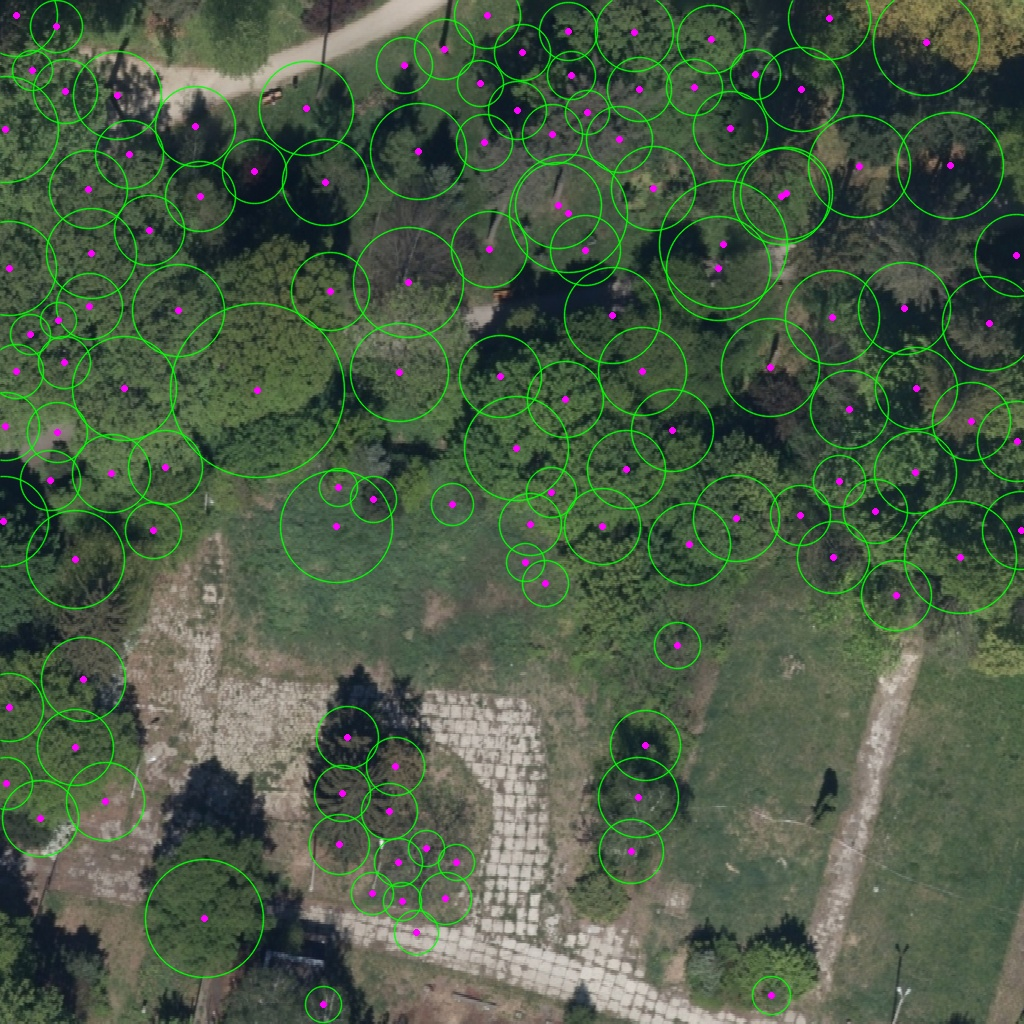

In [ ]:
ds[2]["results"]

In [27]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import json
import numpy as np
import torchvision
from typing import Any

from ellipse_rcnn.utils import data
from ellipse_rcnn.utils.types import TargetDict, ImageTargetTuple, EllipseTuple
from ellipse_rcnn.utils.conics import (
    bbox_ellipse,
    ellipse_to_conic_matrix,
    conic_center,
    unimodular_matrix,
)
from ellipse_rcnn.utils.data.base import EllipseDatasetBase, collate_fn
from torch.utils.data import DataLoader, random_split

class Trees(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        if transform is None:
            self.transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                    ),
                ]
            )
        else:
            self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def get_target(self, idx):

        # (x,y,r)
        circles_list = self.dataset[idx]["metadata"]["transformed_trees"]

        # convert circles_list to ellipse_list
        ellipses_list = []
        for circle in circles_list:
            # circle is a jsob object with keys x, y, r, lat, lon
            ellipse = {
                "x": circle["x"],
                "y": circle["y"],
                "theta": 0,
                "a": circle["radius"],
                "b": circle["radius"],
            }
            ellipses_list.append(ellipse)

        a = torch.tensor([[e["a"] for e in ellipses_list]])
        b = torch.tensor([[e["b"] for e in ellipses_list]])
        theta = torch.tensor([[e["theta"] for e in ellipses_list]])
        x = torch.tensor([[e["x"] for e in ellipses_list]])
        y = torch.tensor([[e["y"] for e in ellipses_list]])

        ellipse_matrices = ellipse_to_conic_matrix(a=a, b=b, x=x, y=y, theta=theta)

        if torch.stack(conic_center(ellipse_matrices)).isnan().any():
            raise ValueError("NaN values in ellipse matrices. Please check the data.")

        if len(ellipse_matrices.shape) == 2:
            ellipse_matrices = ellipse_matrices.unsqueeze(0)

        boxes = bbox_ellipse(ellipse_matrices, box_type="xyxy")

        num_objs = len(boxes)

        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = TargetDict(
            boxes=boxes,
            labels=labels,
            image_id=image_id,
            area=area,
            iscrowd=iscrowd,
            ellipse_matrices=ellipse_matrices,
        )

        return target

    def __getitem__(self, idx):
        # Pobranie przykładu z datasetu Hugging Face
        example = self.dataset[idx]

        # Załadowanie obrazka
        image = example["images"]

        # Pobranie targetu
        target = self.get_target(idx)

        return image, target


class TreesLightningDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data,
        batch_size: int = 16,
        train_fraction: float = 0.8,
        transform: Any = None,
        num_workers: int = 0,
    ) -> None:
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.train_fraction = train_fraction
        self.transform = transform
        self.dataset: Trees | None = None
        self.train_dataset = None
        self.val_dataset = None
        self.num_workers = num_workers

    def prepare_data(self) -> None:
        # Ensure data preparation or downloading is done here.
        pass

    def setup(self, stage: str | None = None) -> None:
        # Instantiate the Trees dataset and split it into training and validation subsets.
        self.dataset = Trees(self.data, transform=self.transform)

        train_size = int(len(self.dataset) * self.train_fraction)
        val_size = len(self.dataset) - train_size
        self.train_dataset, self.val_dataset = random_split(
            self.dataset, [train_size, val_size]
        )

    def train_dataloader(self) -> DataLoader[ImageTargetTuple]:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=self.num_workers,
        )

    def val_dataloader(self) -> DataLoader[ImageTargetTuple]:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            collate_fn=collate_fn,
            num_workers=self.num_workers,
        )

    def test_dataloader(self) -> DataLoader[ImageTargetTuple]:
        # Placeholder for test data; currently returns the validation dataloader as a default.
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, collate_fn=collate_fn
        )

tensor([9767])


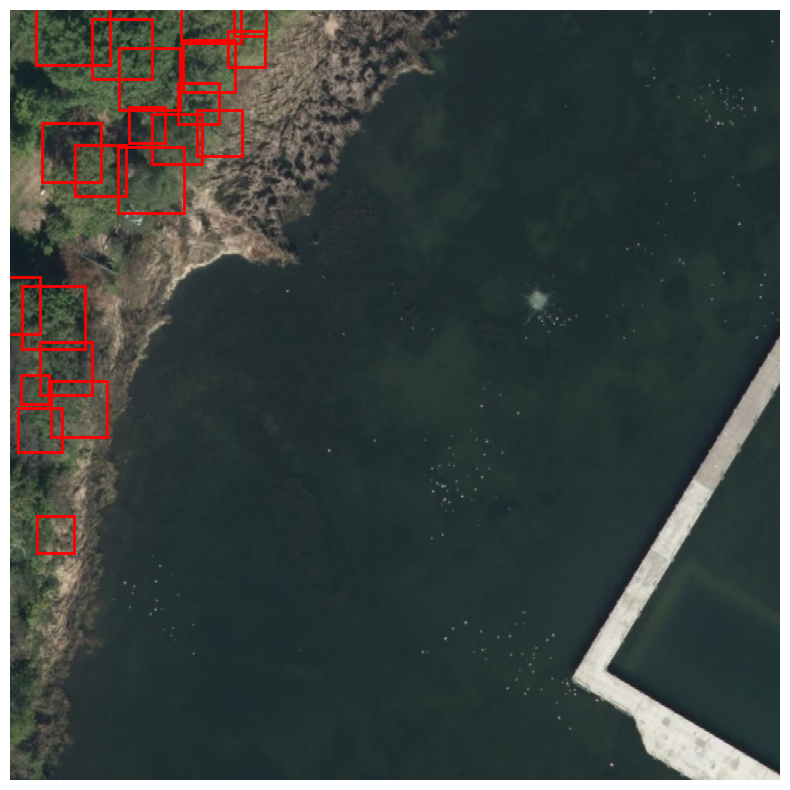

In [45]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl

# Initialize the Lightning Data Module
data_module = TreesLightningDataModule(
    data=ds,
    batch_size=1,  # Fetch a single example for visualization
    train_fraction=0.8,
    transform=T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    num_workers=0,
)

# Prepare and set up the data
data_module.prepare_data()
data_module.setup()

# Get the training dataloader
train_loader = data_module.train_dataloader()

# Fetch the first batch
for images, targets in train_loader:
    image = images[0]  # Single image
    target = targets[0]  # Corresponding target
    break

# Reverse normalization for visualization
# mean = torch.tensor([0.485, 0.456, 0.406])
# std = torch.tensor([0.229, 0.224, 0.225])
# image = T.ToTensor()(image)  # Convert PIL image to tensor
# image = image.permute(1, 2, 0) * std + mean  # HWC format, reverse normalization
# image = image.numpy()

# Display the image and bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
#print image it and show id from results ds

print(target["image_id"])

# Plot bounding boxes
boxes = target["boxes"]
for box in boxes:
    x_min, y_min, x_max, y_max = box.numpy()
    plt.gca().add_patch(
        plt.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
    )

plt.show()

# Print the target dictionary

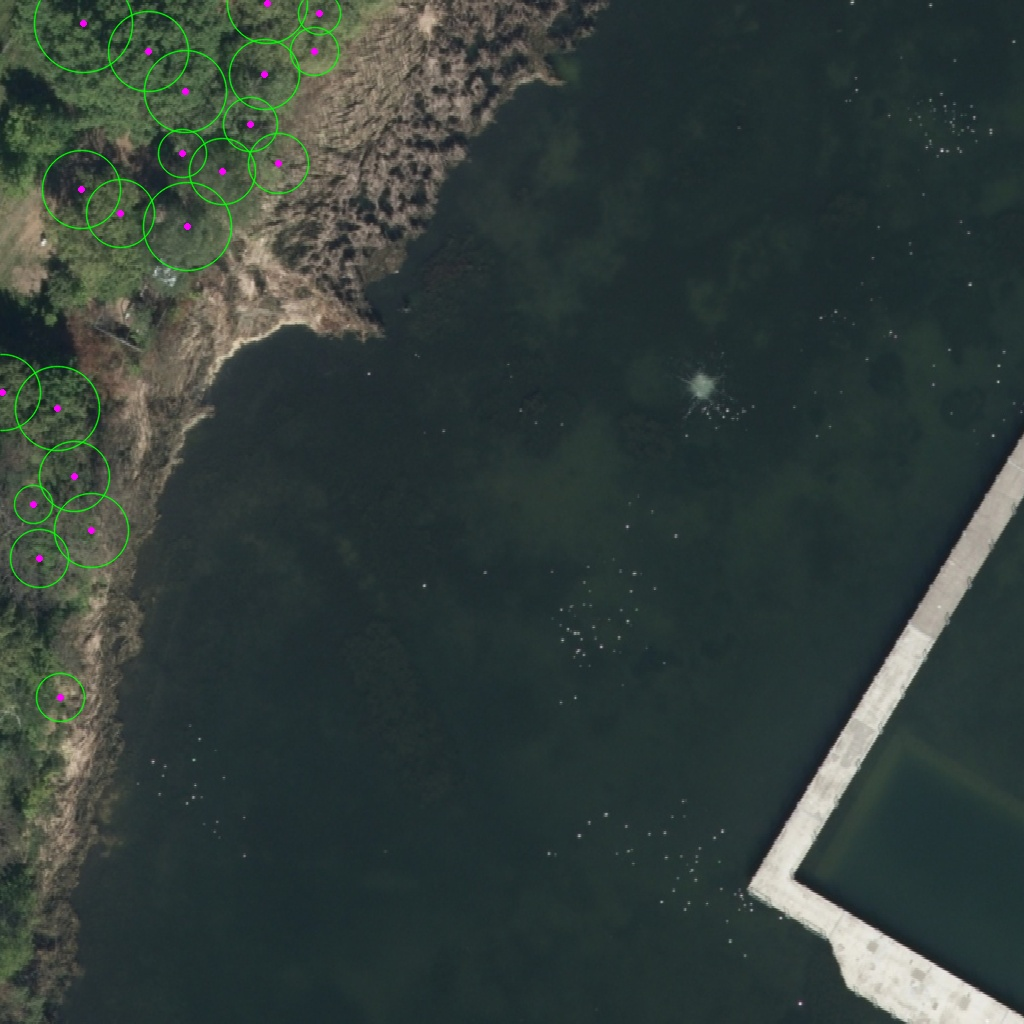

In [51]:
ds[target["image_id"].item()]["results"]

In [52]:
# TODO: Implement the model training  with the Lightning Trainer  and our data module.
